In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import sys
import random
import math
import time
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Soluciones Iniciales

In [34]:
df_aristas = pd.read_csv("data-ejemplo/aristas.csv")
df_vertices = pd.read_csv("data-ejemplo/nodos.csv")

In [35]:
class Vertex:
    def __init__(self, node,lon,lat,cont):
      rand = random.randrange(9000,100000)
      self.id = node
      self.adjacent = {}
      # Distancia infinito para todos los nodos (infinito es un random grande)
      self.distance = rand
      self.distanceG = rand
      self.distanceF = rand
      # Todos los nodos inician como no visitados    
      self.visited = False  
      # prev
      self.previous = None
      #longitud y latitud
      self.longitud = lon
      self.latitud = lat
      self.cont = cont #identificador unico para cada vertice (a parte del id)

    def agregar_vecino(self, neighbor, weight=0):
      self.adjacent[neighbor] = weight

    def obtener_conexiones(self):
      return self.adjacent.keys()  

    def obtener_id(self):
      return self.id

    def obtener_peso(self, neighbor):
      return self.adjacent[neighbor]

    def agregar_distancia(self, dist):
      self.distance = dist

    def obtener_distancia(self):
      return self.distance

    def agregar_distanciaG(self, dist):
      self.distanceG = dist

    def obtener_distanciaG(self):
      return self.distanceG

    def agregar_distanciaF(self, dist):
      self.distanceF = dist

    def obtener_distanciaF(self):
      return self.distanceF

    def obtener_lon(self):
      return self.longitud

    def obtener_lat(self):
      return self.latitud

    def agregar_previous(self, prev):
      self.previous = prev

    def visitado(self):
      self.visited = True

    def __str__(self):
      return str(self.id) + ' adjacent: ' + str([x.id for x in self.adjacent])

class Graph:
  def __init__(self):
    self.vert_dict = {}
    self.num_vertices = 0

  def __iter__(self):
    return iter(self.vert_dict.values())

  def agregar_vertice(self, node,lon,lat,cont):
    self.num_vertices = self.num_vertices + 1
    new_vertex = Vertex(node,lon,lat,cont)
    self.vert_dict[node] = new_vertex
    return new_vertex

  def obtener_vertice(self, n):
    if n in self.vert_dict:
      return self.vert_dict[n]
    else:
      return None

  def agregar_arista(self, frm, to, cost = 0):
    if frm not in self.vert_dict:
      self.agregar_vertice(frm)
    if to not in self.vert_dict:
      self.agregar_vertice(to)

    self.vert_dict[frm].agregar_vecino(self.vert_dict[to], cost)
    self.vert_dict[to].agregar_vecino(self.vert_dict[frm], cost)

  def obtener_vertices(self):
    return self.vert_dict.keys()
  
  def obtener_vertices_nodes(self):
    return self.vert_dict.values()

  def agregar_previous(self, u):
    self.previous = u

  def obtener_previous(self, u):
    return self.previous

In [36]:
#N = Número de individuos
# G = Grafo
#s = nodo inicial
#t = nodo final
def esBucle(nodo):
  banderas = []
  adyacentes = nodo.obtener_conexiones()
  for adyacente in adyacentes:
    if adyacente.visited == True:
      banderas.append(True)
    else: banderas.append(False)
  if(len(banderas) == 1): return banderas[0]
  for i in range(len(banderas) - 1):
    if(i == 0):
      respuesta = banderas[i] and banderas[i+1]
    else:
      respuesta = respuesta and banderas[i+1]
  return respuesta

In [37]:
def poblacionInicial(N, s, t, G):
    poblacion = []
    for i in range(N):
        actual = s
        individuo = []
        individuo.insert(0,s)
        actual.visited = True
        while(actual != t):
            adyacentes = list(actual.obtener_conexiones())
            nodo = random.choice(list(adyacentes))
            if(esBucle(nodo) and nodo != t):
                nodo.visited = True
            if(nodo.visited == False):
                if(actual not in individuo):
                    individuo.append(actual)
                individuo.append(nodo)
                nodo.visited = True
                actual = nodo
            if(esBucle(actual) and actual != t):
                actual.visited = True
                actual = individuo.pop()
        poblacion.append(individuo)
        for vertice in list(G.obtener_vertices_nodes()):
            vertice.visited = False
    return poblacion

In [38]:
def f(x):
    return x
def fitness(individuo):
    suma = 0
    for i in range(len(individuo) - 1):
        suma = suma + individuo[i].obtener_peso(individuo[i+1])
    return suma

# Operación de Cruzamiento

In [39]:
def crossover(x1, x2, CROSSOVER_RATIO):
    if(random.random()<= CROSSOVER_RATIO):
        inicio = x1[0]
        final = x1[-1]
        for i in range(len(x1)):
            if x1[i] in x2 and x1[i] is not inicio and x1[i] is not final:
                corte1 = i + 1
                for j in range(len(x2)):
                    if x2[j] == x1[corte1 - 1]:
                        corte2 = j + 1
                aux = x1.copy()
                x1[corte1:] = x2[corte2:]
                x2[corte2:] = aux[corte1:]
                return x1,x2
    return x1,x2

In [40]:
individuo1 = [1, 5, 4, 6, 7]
individuo2 = [1, 3, 4, 6, 7]
rate = 0.9
print(crossover(individuo1, individuo2,rate))

([1, 5, 4, 6, 7], [1, 3, 4, 6, 7])


# VNS sobre cada individuo

In [41]:
def vns(individuo):
    return individuo

# Selección proporcional para elegir los padres a realizar crossover

In [42]:
def operaciones_seleccion_proporcional(cadbin, best, num_padres, CROSSOVER_RATE,MUTATION_RATE):
  c = np.ndarray([],dtype=object) #padres
  h = [] #hijos
  prob = []
  #Llevando los valores más bajos arriba, y los más altos abajo, ya que lo que quiero es minimizar
  F = []
  for i in range(len(best)):
    F.append(max(best) - best[i] + 1e-6)
  for i in range(len(F)):
    prob.append((F[i]+100)/(sum(F)+(100*len(F))))
  #num_padres siempre es par
  c = np.random.choice(cadbin.copy(),num_padres,replace=False, p=prob)
  indice2 = 0
  for i in range(int(num_padres/2)):
    c1 , c2 = crossover(c[indice2], c[indice2+1],CROSSOVER_RATE)
    h.append(c1)
    h.append(c2)
    indice = indice2 - 1
    for k in range(2): #Siempre será 2, pues evaluamos a los dos nuevos hijos
      cadbin.append(h[indice+1])
      indice = indice+1
    indice2 = indice2+2
  return cadbin

# Selección Elitista para pasar a la siguiente generación

In [43]:
def select_prob(cadbin, POBLACION): #Se seleccionan las POBLACION mejores soluciones para la siguiente generacion
  pesos = []
  probs = []
  next_generation = []
  for i in range(len(cadbin)):
    pesos.append(fitness(cadbin[i]))
  
  dic = {}
  for i in range(len(cadbin)):
    dic[tuple(cadbin[i])] = pesos[i]
  #dic = dict(zip(cadbin, pesos)) #Convierto mis 2 listas en un diccionario de forma: {"2847140394": 2}
  dic_ordenado = dict(sorted(dic.items(), key=lambda x: x[1])) #Ordeno según los pesos (valores del diccionario)
  next_generation = list(dic_ordenado.keys())
  for i in range(len(next_generation)):
    next_generation[i] = list(next_generation[i])
  return next_generation[0:POBLACION]

In [44]:
# l1 = ["piña", "pacai", "cereza", "manzana", "mandarina"]
# l2 = [-34, 12, 10, 5, -18]
# dic = dict(zip(l1,l2))
# dic_o = dict(sorted(dic.items(), key=lambda x: x[1]))
# print(dic_o)

# Algoritmo genetico

N = Número de individuos de la población inicial. \
Generaciones = número de generaciones. \
num_padres = numero de padres que se utilizarán para realizar crossover.\
s = vértice inicial.\
t = vértice final.\
g = grafo

In [45]:
def AG_caminoMinimo(N,GENERACIONES,CROSSOVER_RATE,MUTATION_RATE, num_padres, s, t, g):
    cadbin = poblacionInicial(N,g.obtener_vertice(s), g.obtener_vertice(t),g)
    POBLACION = N
    mejores_por_generacion = []
    mejor = []
    for j in range(N):
        mejor.append(fitness(cadbin[j]))
    mejores_por_generacion.append(min(mejor))
    ##Inicio del algoritmo
    for i in range(GENERACIONES):
        best = []
        mejor = []
        for j  in range(N):
            best.append(fitness(cadbin[j]))
        cadbin = operaciones_seleccion_proporcional(cadbin, best, num_padres, CROSSOVER_RATE, MUTATION_RATE)
        N = len(cadbin)
        best = []
        for j in range(N):
            best.append(fitness(cadbin[j]))
        cadbin = select_prob(cadbin, POBLACION)
        N = len(cadbin)
        for j in range(N):
            mejor.append(fitness(cadbin[j]))
        mejores_por_generacion.append(min(mejor))
    respuestas = []
    for i in range(len(cadbin)):
        respuestas.append(fitness(cadbin[i]))
    print("mejor fitness final: ", min(respuestas))
    return mejores_por_generacion

mejor fitness final:  397.87617345553167


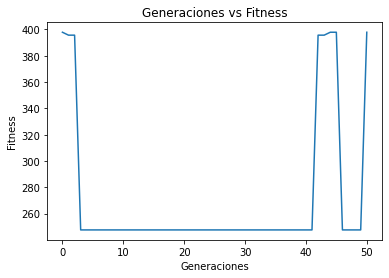

In [46]:
g = Graph()
for i in range(df_vertices.shape[0]):
  g.agregar_vertice(df_vertices["id"][i], df_vertices["lon"][i], df_vertices["lat"][i],i)

for j in range(df_aristas.shape[0]):
  g.agregar_arista(df_aristas["source"][j],df_aristas["target"][j],df_aristas["length"][j])

N = 15
num_padres = 6
s = 5394544018
t = 5394544016

CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1
GENERACIONES = 50
f = AG_caminoMinimo(N, GENERACIONES, CROSSOVER_RATE, MUTATION_RATE, num_padres, s, t, g)

plt.title("Generaciones vs Fitness")
plt.plot(f)
plt.ylabel("Fitness")
plt.xlabel("Generaciones")
plt.show()

mejor fitness final:  17603.852887912548


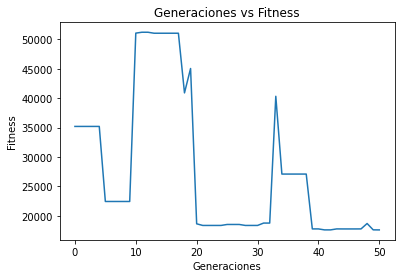

In [50]:
vertices3 = pd.read_csv("mapas/mapa3/nodes3.csv")
aristas3 = pd.read_csv("mapas/mapa3/edges3.csv")

g = Graph()
for i in range(vertices3.shape[0]):
  g.agregar_vertice(vertices3["id"][i], vertices3["lon"][i], vertices3["lat"][i],i)

for j in range(aristas3.shape[0]):
  g.agregar_arista(aristas3["source"][j],aristas3["target"][j],aristas3["length"][j])

N = 20
num_padres = 8
s = 4261133139
t = 9740583462

CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.1
GENERACIONES = 50
f = AG_caminoMinimo(N, GENERACIONES, CROSSOVER_RATE, MUTATION_RATE, num_padres, s, t, g)

plt.title("Generaciones vs Fitness")
plt.plot(f)
plt.ylabel("Fitness")
plt.xlabel("Generaciones")
plt.show()

# Dijkstra

In [48]:
def dijkstra(aGraph, start, target):
    '''Algoritmo de Dijkstra'''
    # distancia del nodo inicial = 0
    start.agregar_distancia(0)

    # se colocarán todas las tuplas (distancia,vertice) en una cola de prioridad (Q)
    Q = []
    dic = {} #diccionario donde almaceno id,vertice
    nodos_expandidos = 0
    for v in aGraph:
        dic[v.cont] = v
        Q.append((v.obtener_distancia(),v.cont))
    heapq.heapify(Q)
    #nodos_open = []
    while len(Q):
        nodos_expandidos +=1
        # Hacemos pop a la tupla (distancia, vertice) con menor distancia de Q
        uv = heapq.heappop(Q) #Se asigna y se elimina u de Q
        #nodos_open.append(uv)
        u = dic.get(uv[1]) #Se obtiene el vértice
        u.visitado()
        #Sale del algoritmo de Dijkstra
        if(u.id == target.id):
            u_copia = u
            camino = []
            camino.append(u_copia.id)
            if(u_copia.previous):
                while(u_copia.previous):
                    camino.append(u_copia.previous.id)
                    u_copia = u_copia.previous
                #print(u.obtener_distancia(), camino[::-1])
                #print(nodos_open)
                print("longitud camino mínimo: ",len(camino))
                print("vértices expandidos: ",nodos_expandidos)
                eficiencia = len(camino)/nodos_expandidos
                print("Eficiencia: ", eficiencia)
                return u.obtener_distancia(), camino[::-1]

        # Para cada vertice vecino v de u :
        for v in u.adjacent:
            if v.visited:
                continue
            new_dist = u.obtener_distancia() + u.obtener_peso(v)
            
            if new_dist < v.obtener_distancia():
                v.agregar_distancia(new_dist)
                v.agregar_previous(u)  

        #Refresh de la cola de prioridad
        # 1. Hacemos pop de todos los items
        while len(Q):
            heapq.heappop(Q)
        # 2. Actualizamos todos los vértices no visitados del grafo
        dic = {} #diccionario donde almaceno id,vertice
        for v in aGraph:
            if not v.visited:
                dic[v.cont] = v
                Q.append((v.obtener_distancia(),v.cont))
        heapq.heapify(Q)

In [49]:
g = Graph()
for i in range(df_vertices.shape[0]):
  g.agregar_vertice(df_vertices["id"][i], df_vertices["lon"][i], df_vertices["lat"][i],i)
s = 5394544018
t = 5394544016

for j in range(df_aristas.shape[0]):
  g.agregar_arista(df_aristas["source"][j],df_aristas["target"][j],df_aristas["length"][j])
inicio = time.time()
distancia, camino_min = dijkstra(g, g.obtener_vertice(s), g.obtener_vertice(t)) 
fin = time.time()
print("Tiempo: ",fin - inicio) 
print("Distancia mínima: ", distancia)
print("Camino:", camino_min)

longitud camino mínimo:  5
vértices expandidos:  11
Eficiencia:  0.45454545454545453
Tiempo:  0.0010323524475097656
Distancia mínima:  221.12913789532936
Camino: [5394544018, 1209248504, 5394544017, 5394544015, 5394544016]
